## Imports

In [ ]:
import numpy as np                 # linear algebra
import pandas as pd                # data processing
import matplotlib.pyplot as plt    # basic plotting library
import seaborn as sns              # more advanced visual plotting library

## Data visualization
MAGIC gamma telescope data 2004

In [3]:
headers = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "fClass"]
df = pd.read_csv('magic04.data', names=headers)
mapping = {'g': 1, 'h': 0}
df["fClass"] = df["fClass"].map(mapping)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(data=df.corr(),annot=True,cmap="bone",linewidths=1,fmt=".2f",linecolor="gray")
plt.title("Correlation Map",fontsize=20)
plt.tight_layout()
plt.show()      # lightest and darkest cells are most correlated ones

In [ ]:
sns.pairplot(data=df,
             palette="husl",
             hue="fClass",
             vars=headers)
plt.suptitle("PairPlot of Data Without Std. Dev. Fields",fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
print(len(df[df['fAlpha'] == 0]))
print(len(df[df['fAlpha'] == 90]))
print(len(df[df['fSize'] == 0]))
print(len(df[df['fLength'] == 0]))
print(len(df[df['fWidth'] == 0]))
df[df['fWidth'] < 1].hist(column='fWidth', bins=100)
df[df['fWidth'] == 0].hist(column='fSize', bins=100)

## Data pre-processing

In [21]:
df_rescaled = pd.DataFrame()
headers = ["fLength", "fWidth", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist","fAlpha", "fSize","fClass"]
rescaled_headers = [ "rescaled_length", "rescaled_width","rescaled_conc","rescaled_conc1"  ,"rescaled_asym","rescaled_M3long" ,"rescaled_M3trans","rescaled_dist" ,"alpha","size","rad"]
for i in range(0,8):
    df_rescaled.insert(i, rescaled_headers[i] ,df[headers[i]]/df["fSize"])
df_rescaled.insert(8, "alpha" ,df["fAlpha"])
df_rescaled.insert(9, "size" ,df["fSize"])
df_rescaled.insert(10, "rad" ,df["fClass"])
# df_rescaled.describe()

In [54]:
# # df.drop(df[df.fWidth == 0].index, inplace=True) # Drops rows where fWidth == 0

Y = df["fClass"].values
# todrop = ["fLength", "fWidth", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist","fAlpha", "fSize","fClass"]
# todrop = [ "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fDist","fClass"]
# todrop = [ "fClass"]
input_shape = (10,)
to_abolish = ["fClass"]
X = df.drop(to_abolish,axis=1).values

# Y = df_rescaled["rad"].values
# X = df_rescaled.drop(["rad"],axis=1).values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Fischers linear discriminant
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# model = LinearDiscriminantAnalysis()
# model.fit(X, Y)
# X = model.transform(X)
# input_shape = (1,)

# PCA
from sklearn.decomposition import PCA
n = 3
modelPCA = PCA(n_components=n)
#project data on principal components
X = modelPCA.fit_transform(X)
input_shape = (n,)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.05,random_state=42)

## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver="sag", C=0.1, penalty="l2", tol=1e-20, max_iter=100, random_state=100)
lr_model.fit(x_train, y_train)
lr_score = lr_model.score(x_test, y_test)
lr_pred = lr_model.predict(x_test)
print("lr_score: ", lr_score)

from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(y_test,lr_model.predict_proba(x_test)[:, 1])
print("roc_score: ",roc_score)


lr_score:  0.7812828601472135
roc_score:  0.8174793485495048


C:\Users\basti\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


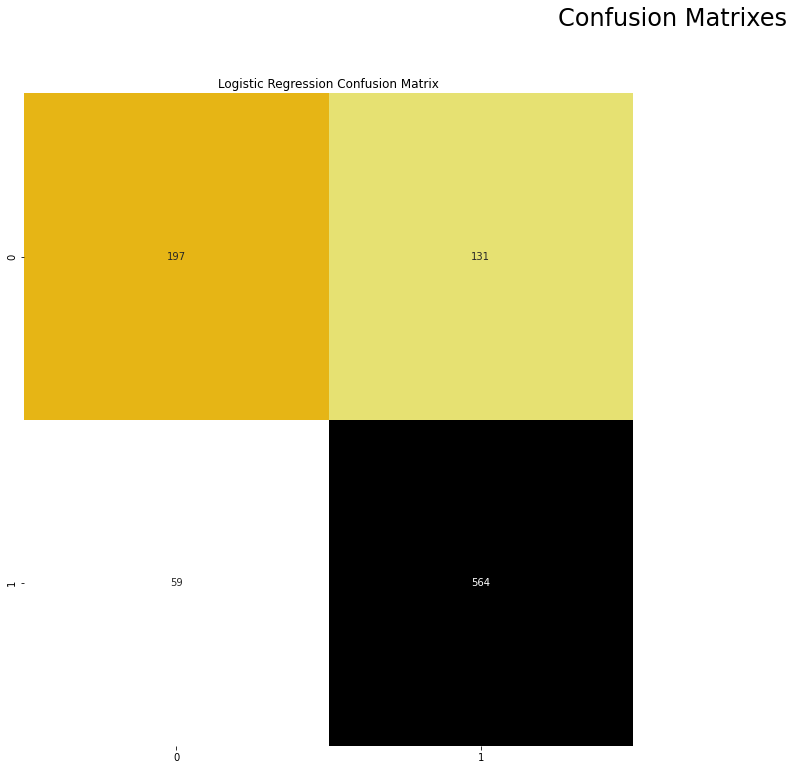

In [11]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test,lr_pred)

plt.figure(figsize=(24,12))
plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplot(1,2,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,cbar=False,annot=True,cmap="CMRmap_r",fmt="d")

plt.show()

## Deep Neural Network

In [56]:
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

In [57]:
# look for theory about no of parameters vs data rows
# test different activation functions
# check classifiers
# check general pourpose layers instead of dense ones
# check loss function
# check optimizer for loss function

model = Sequential()
#model.add(Flatten(input_shape=(10,)))
#model.add(Dense(10, activation=tf.nn.relu))
#model.add(Dense(5, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu, input_shape=input_shape))
model.add(Dense(1, activation=tf.nn.sigmoid))

#non-working attempt at a custom loss function as in: https://towardsdatascience.com/explicit-auc-maximization-70beef6db14e
# def custom_loss(y_true, y_pred):
#     # calculate loss, using y_pred
#     alpha = tf.sigmoid(y_pred @ tf.transpose(y_pred))
#     beta = np.maximum(y_true @ np.ones(y_true.shape).T - np.ones(y_true.shape) @ y_true.T)
#     loss = - tf.reduce_mean(alpha * beta, 0)
#     return loss

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])
# model.summary()

print("Number of weights after calling the model:", len(model.weights))

Number of weights after calling the model: 4


In [58]:
dnn_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
181/181 [==============================] - 1s 2ms/step - loss: 0.5313 - accuracy: 0.7658 - val_loss: 0.4624 - val_accuracy: 0.7823
Epoch 2/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7947 - val_loss: 0.4436 - val_accuracy: 0.7939
Epoch 3/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.8024 - val_loss: 0.4376 - val_accuracy: 0.8023
Epoch 4/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.8064 - val_loss: 0.4343 - val_accuracy: 0.8065
Epoch 5/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8062 - val_loss: 0.4357 - val_accuracy: 0.8118
Epoch 6/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.8070 - val_loss: 0.4323 - val_accuracy: 0.8097
Epoch 7/10
181/181 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.8071 - val_loss: 0.4303 - val_accuracy: 0.8076
Epoch 

In [ ]:
plt.plot(dnn_history.history['accuracy'])
plt.plot(dnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

In [ ]:
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

In [59]:
dnn_score = model.evaluate(x_test, y_test)
dnn_pred = model.predict(x_test)

# input_test = np.array([
#     [2,4,3,0.1,0.17,-10,102,-1,3,244],
#     [0.1,0.2,0.3,0.4,0.2412,1,0.5,-20,1,2]])
# input_pred = model.predict(input_test)
# print("input_pred: ",input_pred)

from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(y_test,dnn_pred)
print("roc score: ", roc_score)

30/30 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.8055
roc score:  0.8469443683200876
